In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import copy
import handcalcs
import handcalcs.render
from math import log, sqrt

In [2]:
from bokeh.io import output_notebook, show, curdoc
from bokeh.plotting import figure
from bokeh.layouts import column, row, gridplot
from bokeh.transform import factor_cmap, linear_cmap
from bokeh.palettes import Spectral6
from bokeh.models import ColumnDataSource, HoverTool, Select, Range1d, Paragraph, TextInput, Slider, LinearColorMapper
from bokeh.models.widgets import Slider, Button, TextInput, NumericInput
from bokeh.models.widgets import DataTable, TableColumn, RangeSlider
from bokeh.transform import dodge

In [3]:
output_notebook()

Loading BokehJS ...

In [4]:
class Bandit():
    
    def __init__(self, random_chance):
        #print("Bandit made")
        self.succes_chance = random_chance
        self.win = 0
        self.total_pulls = 0
        #we initialize the machine with a true succes chance of 50%
        self.true_succes = 1
        self.historical_succes = []
        #print(self.succes_chance)
        
    def pull_lever(self):
        pull = random.uniform(0,100)
        if pull <= self.succes_chance:
            #print(pull, self.succes_chance)
            self.win += 1
            self.total_pulls += 1
            self.true_succes = self.win / self.total_pulls
            self.historical_succes.append(self.true_succes)
            return 2
        else:
            #print(pull, self.succes_chance)
            self.total_pulls += 1
            self.true_succes = self.win / self.total_pulls
            self.historical_succes.append(self.true_succes)
            return 0
        
    def pull_x(self, x):
        pulls = np.random.randint(0,100, size = x)
        return pulls >= self.succes_chance
    
    def calc_succes_deviation(self):
        return (self.true_succes * 100) - self.succes_chance 
    
    def hist_calc_succes_deviation(self):
        mod_chance = self.succes_chance / 100
        return np.array(self.historical_succes) - mod_chance

In [5]:
class Session():
    
    def __init__(self, num_bandits, running_amount, given_seed, lower, upper, method):
        
        #initialize the random seed so we can compare our exploration algo's
        random.seed(given_seed)
        
        colors = ["green", "red", "blue"]
        
        self.method = method
        self.color = colors[method -1]
        self.num_bandits = num_bandits
        self.bandits = []
        self.starting_amount = running_amount
        self.running_amount = 0
        self.bandit_pulled = []
        self.session_history = []
        self.historical_ucbs = []
        self.ucbs = []
        self.true_succes_rates = []
        self.algo_components = {}
        self.preferred_algo = "placeholder"
        
        for i in range(num_bandits):
            self.add_bandit(lower, upper)
            #self.ucbs.append(self.bandits[i].true_succes)
            self.ucbs.append(2)
            self.true_succes_rates.append(self.bandits[i].succes_chance)
            
        self.mean = np.array(self.true_succes_rates).mean()
        self.median = np.median(self.true_succes_rates)
        
        
        s_rates = np.array(self.true_succes_rates) - 50
        s_rates = s_rates * s_rates
        self.u_metric = s_rates.sum() / self.num_bandits

    def add_bandit(self, lower, upper):
        b = Bandit(random.randint(lower, upper))
        self.bandits.append(b)
        
    def pull_lever(self, b_choice):
        self.bandit_pulled.append(b_choice)
        self.running_amount += -1
        self.running_amount += self.bandits[b_choice].pull_lever()
        self.session_history.append(self.running_amount)
        
        self.calc_ucb()
    
    def get_ucbs_list(self):
        return list(map(lambda x: x * 100, self.ucbs))
    
    def get_status(self):
        for i in range(self.num_bandits):
            print(f"Bandit {i} has a true succes of {round(self.bandits[i].true_succes * 100,4)}, {self.bandits[i].succes_chance}")
    
    def get_milestone(self, milestone):
        try:
            return self.session_history.index(milestone) + 1
        except:
            return 0
        
    def get_list_of_milestones(self, milestones):
        return list(map(lambda x: self.get_milestone(x), milestones))
    
    def calc_ucb(self):
        
        bounds = []
        
        #for every pull performed we have to recalculate the upper confidence bounds of all bandits
        #we use the UCB formula "True succes + Square root of the Log of total pulls divided by the individual bandit pulls"
        #bandit.true_succes + math.sqrt(math.log(len(self.session_history)) / bandit.total_pulls))
        if self.method == 1:
            for i in range(self.num_bandits):
                try:
                    bounds.append(
                        self.bandits[i].true_succes + (math.log(len(self.session_history)) / self.bandits[i].total_pulls)
                    )
                except :
                    bounds.append(2)
                
        if self.method == 2:
            for i in range(self.num_bandits):
                try:
                    bounds.append(
                        self.bandits[i].true_succes +  math.sqrt(math.log(len(self.session_history)) / self.bandits[i].total_pulls)
                    )
                except :
                    bounds.append(2)

        #Method UCB-1
        if self.method == 3:
            for i in range(self.num_bandits):
                #try to set the bounds
                try:
                    bounds.append(
                        #√( (logN / n)
                        math.sqrt(
                                math.log((len(self.session_history)) / self.bandits[i].total_pulls)
                        )
                        
                        *
                        
                        (-0.25 *
                         
                        #Σ(x_i² / n) - (Σ x_i / n)²
                        (
                            (self.bandits[i].running_amount ** self.bandits[i].running_amount) / self.bandits[i].total_pulls) - 

                                (
                                    (self.bandits[i].running_amount / self.bandits[i].total_pulls * 
                                    (self.bandits[i].running_amount/ self.bandits[i].total_pulls
                                )
                            )
                        
                            +
                                    
                            #√(2log(N) / n)                             
                            math.sqrt(
                                math.log((2 * (len(self.session_history))) / self.bandits[i].total_pulls))
                            )
                        )
                    )  
                except :
                    bounds.append(2)
        
        
        #add upper confidence bounds to the historical list and to the current list
        self.historical_ucbs.append(bounds)
        self.ucbs = bounds
    
    def visualize_hist(self):
        fig, axes = plt.subplots(self.num_bandits, figsize = [20,10])
        x = list(range(0,self.bandits[0].total_pulls))
        fig.suptitle(f"Historical succes of {self.num_bandits} Bandits")
        
        # plot lines
        for i in range(len(self.bandits)):
            x = list(range(0,self.bandits[i].total_pulls))
            axes[i].plot(x, self.bandits[i].hist_calc_succes_deviation(), label = f"Bandit {i}: {self.bandits[i].succes_chance}")
            
            axes[i].legend(bbox_to_anchor=(1.1, 1.05))
            
    
        plt.show()
        
    
    def retrieve_true_succes(self):
        return list(map(lambda x: x.true_succes * 100, self.bandits))
    

In [6]:
class Sim():
    
    def __init__(self):
        self.sessions = []
        self.averaged_returns = []
        
        
    def add_session(self, num_of_bandits, pulls, seed, lower_bound, upper_bound, method):
        self.sessions.append(Session(num_of_bandits, pulls, seed, lower_bound, upper_bound, method))
       
    def pull_all_levers(self, num_pulls):

        for session in self.sessions:
            for ii in range(num_pulls):
                session.pull_lever(session.ucbs.index(max(session.ucbs)))
            #self.averaged_returns.append(self.retrieve_centroids_sum(self.retrieve_methods(), self.retrieve_returns()))
    
    def retrieve_medians(self):
        return list(map(lambda x: x.median, self.sessions))
        
    def retrieve_means(self):
        return list(map(lambda x: x.mean, self.sessions))
    
    def milestone_matrix(self, milestones):
        return list(map(lambda x: x.get_list_of_milestones(milestones), self.sessions))
    
    def retrieve_returns(self):
        return list(map(lambda x: x.running_amount, self.sessions))
    
    def retrieve_returns_history(self):
        return list(map(lambda x: x.session_history, self.sessions))
    
    def retrieve_num_bandits(self):
        return list(map(lambda x: x.num_bandits, self.sessions))
    
    def retrieve_methods(self):
        return list(map(lambda x: x.method, self.sessions))
    
    def retrieve_colors(self):
        return list(map(lambda x: x.color, self.sessions))
    
    def retrieve_u_metric(self):
        return list(map(lambda x: x.u_metric, self.sessions))
    
    def retrieve_centroids(self, m, r):
        result = []
        methods = list(set(m))

        #loop through all different methods to get one centroid
        for i in range(len(methods)):
            m2 = np.array(m) == methods[i]
            r2 = np.array(r)[m2].mean()
            result.append(r2)
            
        return result
    
    def calc_return_history(self, m, r):
        result = []
        methods = list(set(m))

        #loop through all different methods to get one centroid
        for i in range(len(methods)):
            m2 = np.array(m) == methods[i]
            r2 = np.array(r)[m2]
            result.append(r2)
            
        avgs = []
        for i in range(len(result)):
            avgs.append([])
            for ii in range(len(result[i][0])):
                avgs[i].append(
                    np.array(
                        list(map(lambda x: x[ii], result[i]))).sum())    
        
        return avgs
    
    def retrieve_averaged_returns(self):
        res = []
        
        for i in range(len(self.averaged_returns[0])):
            res.append(list(map(lambda z: z[i], list(self.averaged_returns))))
            
        return res

C = √( (logN / n) x min(1/4, V(n)) )
where V(n) is an upper confidence bound on the variance of the bandit, i.e.
V(n) = Σ(x_i² / n) - (Σ x_i / n)² + √(2log(N) / n)
and x_i are the rewards gained from the bandit so far.

In [11]:
%%render
S = 0.5
N = 100
n = 20
C = S + log(N/n)

<IPython.core.display.Latex object>

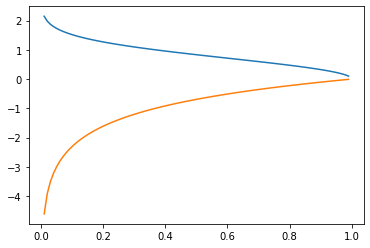

In [12]:
r = np.arange(1,100) / 100
t = r / 10

plt.plot(r ,np.array(list(map(lambda x: sqrt(abs(math.log(x))), r))))
plt.plot(r, np.array(list(map(lambda x: math.log(x), r))))
plt.show()

We can't simply use the succes rates per machine because of randomness.<br>
Bandits with a 80% pay out chance still has a 1% chance to lose 3 times in a row.<br>
With a lower pay out rate like 55% the chance of losing 3 times in row rises to 17%.<br>

When we're just starting out with our gambling session it makes sense to explore all the different machines<br>
before settling on Bandit that we can prove has the best returns.<br>

It makes sense to use the succes rates in our decision making, we do this naturally as humans.<br>
But we also somehow need to quantify the exploration aspect into a formula.<br>

The formula we'll use going forward will be as follows.<br>
<br>
<b><I>Action Value = Succes Rate + Exploration Value</b></I><br>
<br>
We will calculate an <b>"Action Value"</b> for every machine that is available to us.<br>
Based on the combination of their <b>True succes rate</b> (our returns) and our exploration component we'll compute action values.<br>
We'll pick the machine with the highest action value for our next round.

In [13]:
%%render
#short
#Symbolic
Simple_expl = log(N)/n
Root_expl = sqrt(log(N)/n)

<IPython.core.display.Latex object>

The cell above shows two different algorithms we can use for the Multi Armed Bandit scenario.<br>
<br>
Different components are used such as:<br>
-       natural logarithm (ln)<br>
-       root function (√)<br>
-          total number of rounds (N)<br>
-         times 1 machine was chosen (n)<br>

It can be difficult to imagine how these components influence the action value.<br>
Which is why i made an interactive an interactive dashboard below to discover the effect of different components.

In [93]:
def modify_doc(doc):
    
    #rng = RangeSlider(title="Adjust Range",
    #start=1, end=100, step=1, value=(1, 100),)
    
    big_n = Slider(title = "Number of total actions (N)",
    start=1, end=100, step=1, value=25,)
    
    small_n = Slider(title = "Number of bandit actions(n)",
    start=1, end=50, step=1, value=3,)
    
    tools = ["hover","wheel_zoom"]
    
    width,height = 240,400
    
    def get_range():
        return np.arange(1, 100)
    
    def get_data():
        d = dict(
        x = get_range(),
        y = np.array(list(map(lambda x: log(x) / int(small_n.value), get_range()))),
        log = np.array(list(map(lambda x: log(x), get_range()))),
        root_range = np.arange(0.02,2,0.02),
        root = np.array(list(map(lambda x: sqrt(x), np.arange(0.02,2,0.02)))),
        y_sqrt = np.array(list(map(lambda x: sqrt(log(x) / int(small_n.value)), get_range()))))
        d["diff"] =  d["y_sqrt"] - d["y"]
        return d
    
    def refresh_data(attr, old, new):
        data.data = get_data()
        algos.data = get_algo_data()
        diff.data = get_diffs()
 
    def get_algo_data():
        a = dict( names = ["Simple", "Root"]
                            , calcs = ["Log(N)/n", "Sqrt(log(N)/n)"]
                            , colors = ["green", "red"]
                            , forms = [f"Log({big_n.value}) / {small_n.value}", f"Sqrt(Log({big_n.value}) / {small_n.value})"]
                            , s_forms = [f"{np.round(log(big_n.value),4)} / {small_n.value}", f"Sqrt({np.round(log(big_n.value) / small_n.value,4)})"]
                            , vals = [np.round((log(big_n.value)/small_n.value),4), np.round(float(sqrt(log(big_n.value)/small_n.value)),4)]
                            , x = [big_n.value, big_n.value])
        return a
    
    def get_diffs():
        diffs = dict(
                            x = [big_n.value],
                            y = [(algos.data["vals"][1] - algos.data["vals"][0])],
                            log = [np.round(log(big_n.value),4)],
                            log_val = [np.round((log(big_n.value)/small_n.value),4)],
                            root = [np.round(sqrt((log(big_n.value)/small_n.value)),4)]
                            )
        return diffs
    
    data = ColumnDataSource(get_data())
    algos = ColumnDataSource(get_algo_data())
    diff = ColumnDataSource(get_diffs())
                         
    p = figure(plot_width=width, plot_height=height, title="Simple algo & Root algo", tools = tools)
    p.line(x = "x", y = "y", source = data, legend_label = "S algo", color = "green")
    p.line(x = "x", y = "y_sqrt", source = data, color = "red", legend_label = "R algo")
    
    p.circle(x = "x", y = "vals", source = algos, color = "colors")
    
    p.y_range = Range1d(-1,2)  
    
    p.legend.location = "bottom_right"
    p.legend.title = "Formulas"
    
    p.yaxis.axis_label = "Action value"      
    p.xaxis.axis_label = "Total actions" 
    
    p1 = figure(plot_width=width, plot_height=height, title="Difference of Root A-value minus Log A-value", tools = tools)
    p1.line(x = "x", y = "diff", source = data, legend_label = "Diff", color = "blue")
    p1.circle(x = "x", y = "y", source = diff, color = "blue")
    
    p1.y_range = Range1d(-1,2)  
    
    p1.xaxis.axis_label = "Total actions" 
    p1.yaxis.axis_label = "Action value difference"    
    
    p2 = figure(plot_width=width, plot_height=height, title="Natural logarithm", tools = tools)
    p2.line(x = "x", y = "log", source = data, legend_label = "Log", color = "purple")
    p2.legend.location = "bottom_right"
    p2.circle(x = "x", y = "log", source = diff, color = "purple")
    
    p2.xaxis.axis_label = "Total actions" 
    p2.yaxis.axis_label = "Logarithm of Total actions" 
    
    p3 = figure(plot_width=width, plot_height=height, title="Rooted Logarithms", tools = tools)
    p3.line(x = "root_range", y = "root", source = data, legend_label = "Roots", color = "orange")
    p3.legend.location = "bottom_right"
    p3.circle(x = "log_val", y = "root", source = diff, color = "orange")

    p3.xaxis.axis_label = "Logarithm input" 
    p3.yaxis.axis_label = "Root Value" 
    
    p3.y_range = Range1d(0,4)  
    
    def update_algos():

        diff.data["x"] = [big_n.value]
        diff.data["y"] = [algos.data["vals"][1] - algos.data["vals"][0]]

            
    columns = [
        TableColumn(field="names", title="Names")
        ,TableColumn(field="calcs", title="Formula")
        ,TableColumn(field="forms", title="Display")
        ,TableColumn(field="s_forms", title="Simplified")
        ,TableColumn(field="vals", title="Values")]
    
    data_table = DataTable(source=algos, columns = columns, width=600, height=80)
    
  
    big_n.on_change('value', refresh_data)
    small_n.on_change('value', refresh_data)
    
    
    layout = column(row(big_n, small_n), row(p ,p1, p2, p3),  row( data_table))
        
    # add the layout to curdoc
    doc.add_root(layout)
    
    
#show the doc
show(modify_doc)

In [95]:
def modify_doc(doc):
    
    #global s_counter
    s_counter = 1
    
    global hist
    hist = pd.DataFrame.from_dict({ "Return": 0, "Number of rounds": 0, "Number of Bandits": 0}
                                 , orient = "index").transpose().reset_index( inplace=True)
    
    tools = ["box_select","lasso_select","help","pan","wheel_zoom", "hover"]

    num_of_bandits = NumericInput(title="Number of Bandits", value=5, width = 150)
    num_of_rounds = NumericInput(title="Number of rounds", value=50, width = 100)
    
    bandit_bounds = RangeSlider(
    title="Adjust probability bounds",
    start=1, end=99, step=1, value=(40, 60),    )
    
    button = Button(label="Refresh Session.",  width = 150)
    rounds_button = Button(label="Add rounds+",  width = 100)

    algos = ["base", "square"]
    
    
    def start_session():
        global simulation
        simulation = Sim()
    
    def add_bandits():
        
        global seed
        seed = random.randint(1,10000)
        simulation.add_session(num_of_bandits.value ,100,seed,int(bandit_bounds.value[0]), int(bandit_bounds.value[1]), 1)  
        simulation.add_session(num_of_bandits.value ,100,seed,int(bandit_bounds.value[0]), int(bandit_bounds.value[1]), 2)  

    
    def add_pulls(num_pulls):
        simulation.pull_all_levers(num_pulls)
    
    def get_ucbs():
        ucbs_value = np.array(simulation.sessions[0].get_ucbs_list()) - np.array(simulation.sessions[0].retrieve_true_succes())
        ucbs_value_2 = np.array(simulation.sessions[1].get_ucbs_list()) - np.array(simulation.sessions[1].retrieve_true_succes())
        true_succes = simulation.sessions[0].retrieve_true_succes()
        true_succes_2 = simulation.sessions[1].retrieve_true_succes()
        
        return dict(num_range = list(range(1, (simulation.sessions[0].num_bandits + 1)))
                    , true_succes = true_succes , ucbs_value = ucbs_value), dict(num_range = list(range(1, (simulation.sessions[0].num_bandits + 1)))
                    , true_succes_2 = true_succes_2 , ucbs_value_2 = ucbs_value_2) 
        
    
    def get_num_pulls():
        unique_elements, count = np.unique(simulation.sessions[0].bandit_pulled, return_counts=True)
        unique_elements, count_2 = np.unique(simulation.sessions[1].bandit_pulled, return_counts=True)
        return dict(num_range = list(range(1, (simulation.sessions[0].num_bandits + 1))), pulls_count = list(count),pulls_count_2 = list(count_2))
                                  
    def update_returns():
        
        return dict(num_range = list(range(1, len(simulation.sessions[0].session_history) + 1)), s0_returns = simulation.sessions[0].session_history, s1_returns = simulation.sessions[1].session_history)

        

    start_session()
    add_bandits()
    #add_pulls(num_of_rounds.value)
    add_pulls(50)
           
    data = ColumnDataSource(dict(true_succes = simulation.sessions[0].true_succes_rates, num_range = list(range(1, (simulation.sessions[0].num_bandits + 1)))))
    
    ucb1, ucb2 = get_ucbs()
    ucbs_succes, ucbs_succes_2 = ColumnDataSource(ucb1), ColumnDataSource(ucb2)
    
    p = figure(plot_width=300, plot_height=500, title="Chance of succes", tools = tools)
    p.vbar_stack(["true_succes", "ucbs_value"], x = dodge("num_range", -0.45), width=0.4, source = ucbs_succes, color = ["blue", "green"], legend_label = ["True succes rate", "Simple action value"])
    p.vbar_stack(["true_succes_2", "ucbs_value_2"], x = dodge("num_range", 0), width=0.4, source = ucbs_succes_2, color = ["blue", "red"], legend_label = ["True succes rate", "Rooted action value"])
    
    p.scatter(dodge("num_range", -0.45), "true_succes", color = "black", size = 25,  width = 5, source = data, marker = "dash", legend_label = "Bandit succes rate")
    p.scatter("num_range", "true_succes", color = "black", size = 25,  width = 5, source = data, marker = "dash")
    p.legend.location = "top_right"
    
    #p.vbar(x = dodge("num_range", -0.45), top = "ucbs_value", width=0.4, source = ucbs_succes, color = "green")
    #p.vbar(x = dodge("num_range", 0), top = "ucbs_value_2", width=0.4, source = ucbs_succes, color = "red")
    
    p.y_range = Range1d(0, 100) 
    
    
    #p.scatter("num_range", "ucbs_value", color = "green", size = 25, width = 5, source = ucbs_succes, marker = "dash")
    #p.scatter("num_range", "ucbs_value_2", color = "red", size = 25, width = 5, source = ucbs_succes, marker = "dash")
    
    num_pulls = ColumnDataSource(get_num_pulls())
    
    years = ["ucb", "ucb square"]
    
    num_range = list(range(1, (simulation.sessions[0].num_bandits + 1)))
    x = [ (num_range, algo) for num_range in num_range for algo in algos ]
    counts = sum(zip(num_pulls.data["pulls_count"], num_pulls.data["pulls_count_2"]), ())
    
    source = ColumnDataSource(data=dict(x=x, counts=counts))
    
    p2 = figure(plot_width=300, plot_height=300, title="Lever pull distribution", tools = tools)
    #p2.vbar(x = "x", top = "counts", source = source)
    p2.vbar(x = dodge('num_range', -0.45), top = "pulls_count", width=0.4, source = num_pulls, color = "green")
    p2.vbar(x = dodge('num_range', 0), top = "pulls_count_2", width=0.4, source = num_pulls, color = "red")
    
    p3 = figure(plot_width=300, plot_height=300, title="Session return", tools = tools)

    returns = ColumnDataSource(dict(num_range = list(range(1, len(simulation.sessions[0].session_history) + 1)), s0_returns = simulation.sessions[0].session_history, s1_returns = simulation.sessions[1].session_history))
    p3.line(x = "num_range",y = "s0_returns" ,source = returns, color = "green")
    p3.line(x = "num_range",y = "s1_returns" ,source = returns, color = "red")
    
    #update_returns()

    def add_hist():
                
        addition = pd.DataFrame.from_dict({ "Return": simulation.sessions[0].running_amount - 1000, "Number of rounds": len(simulation.sessions[0].session_history), "Number of Bandits": simulation.sessions[0].num_bandits}
                                   , orient = "index").transpose()
        
        return addition
        
    
    def update():
        
        #global hist
        #hist = pd.concat([hist, add_hist()], axis = 0)

        global seed
        seed += 10

        start_session()
        add_bandits()
        add_pulls(50)
        
        data.data = dict(true_succes = simulation.sessions[0].true_succes_rates, num_range = list(range(1, (simulation.sessions[0].num_bandits + 1))))
               
        ucbs_succes.data, ucbs_succes_2.data = get_ucbs()
           
        num_pulls.data = get_num_pulls()
        
        returns.data = update_returns()
        
        p3 = figure(plot_width=300, plot_height=300, title="Session return", tools = tools)
        
            
    def add_rounds():
        
        add_pulls(num_of_rounds.value)
            
        ucbs_succes.data, ucbs_succes_2.data = get_ucbs()
        
        num_pulls.data = get_num_pulls()
        
        returns.data = update_returns()
        
    #button.on_click(add_hist)
    button.on_click(update)
    
    rounds_button.on_click(add_rounds)
    
    #layout = row(column(num_of_bandits, row(num_of_rounds, rounds_button), upper_bound, lower_bound, button), column(p, p3), p2, p3)
    
    layout = column(row(num_of_bandits, num_of_rounds, rounds_button, bandit_bounds, button),row(p,p2,p3))
    

    # add the layout to curdoc
    doc.add_root(layout)
    
    
#show the doc
show(modify_doc)

In [15]:
def modify_doc(doc):
    
    #global s_counter
    s_counter = 1
    
    global hist
    hist = pd.DataFrame.from_dict({ "Return": 0, "Number of rounds": 0, "Number of Bandits": 0}
                                 , orient = "index").transpose().reset_index( inplace=True)
    
    tools = ["box_select","lasso_select","help","pan","wheel_zoom", "hover"]

    num_of_bandits = NumericInput(title="Number of Bandits", value=5, width = 150)
    num_of_rounds = NumericInput(title="Number of rounds", value=50, width = 100)
    
    bandit_bounds = RangeSlider(
    title="Adjust probability bounds",
    start=1, end=99, step=1, value=(40, 60),    )
    
    button = Button(label="Refresh Session.",  width = 150)
    rounds_button = Button(label="Add rounds+",  width = 100)

    algos = ["base", "square"]
    
    
    def start_session():
        global simulation
        simulation = Sim()
    
    def add_bandits():
        
        global seed
        seed = random.randint(1,10000)
        simulation.add_session(num_of_bandits.value ,100,seed,int(bandit_bounds.value[0]), int(bandit_bounds.value[1]), 1)  
        simulation.add_session(num_of_bandits.value ,100,seed,int(bandit_bounds.value[0]), int(bandit_bounds.value[1]), 2)  

    
    def add_pulls(num_pulls):
        simulation.pull_all_levers(num_pulls)
    
    def get_ucbs():
        print(simulation.sessions[0].retrieve_true_succes(),simulation.sessions[1].retrieve_true_succes())
        print(simulation.sessions[0].get_ucbs_list())
        return dict(num_range = list(range(1, (simulation.sessions[0].num_bandits + 1)))
                    , ucbs_value = simulation.sessions[0].get_ucbs_list()
                    , ucbs_value_2 = simulation.sessions[1].get_ucbs_list()
                    #, true_succes = simulation.sessions[0].retrieve_true_succes()
                   )
    
    def get_num_pulls():
        unique_elements, count = np.unique(simulation.sessions[0].bandit_pulled, return_counts=True)
        unique_elements, count_2 = np.unique(simulation.sessions[1].bandit_pulled, return_counts=True)
        return dict(num_range = list(range(1, (simulation.sessions[0].num_bandits + 1))), pulls_count = list(count),pulls_count_2 = list(count_2))
                                  
    def update_returns():
        
        return dict(num_range = list(range(1, len(simulation.sessions[0].session_history) + 1)), s0_returns = simulation.sessions[0].session_history, s1_returns = simulation.sessions[1].session_history)

        

    start_session()
    add_bandits()
    #add_pulls(num_of_rounds.value)
    add_pulls(50)
           
    data = ColumnDataSource(dict(true_succes = simulation.sessions[0].true_succes_rates, num_range = list(range(1, (simulation.sessions[0].num_bandits + 1)))))
    
    p = figure(plot_width=300, plot_height=600, title="Chance of succes", tools = tools)
    p.vbar(x = dodge("num_range", -0.45), top = "true_succes", width=0.4, source = data)
    p.vbar(x = dodge("num_range", -0.45), top = "true_succes", width=0.4, source = data)
    p.y_range = Range1d(0, 100) 
    
    ucb1, ucb2 = get_ucbs()
    ucbs_succes, ucbs_succes = ColumnDataSource(get_ucbs())
    
    p.scatter("num_range", "ucbs_value", color = "green", size = 25, width = 5, source = ucbs_succes, marker = "dash")
    p.scatter("num_range", "ucbs_value_2", color = "red", size = 25, width = 5, source = ucbs_succes, marker = "dash")
    
    num_pulls = ColumnDataSource(get_num_pulls())
    
    years = ["ucb", "ucb square"]
    
    num_range = list(range(1, (simulation.sessions[0].num_bandits + 1)))
    x = [ (num_range, algo) for num_range in num_range for algo in algos ]
    counts = sum(zip(num_pulls.data["pulls_count"], num_pulls.data["pulls_count_2"]), ())
    
    source = ColumnDataSource(data=dict(x=x, counts=counts))
    
    p2 = figure(plot_width=300, plot_height=300, title="Lever pull distribution", tools = tools)
    #p2.vbar(x = "x", top = "counts", source = source)
    p2.vbar(x = dodge('num_range', -0.45), top = "pulls_count", width=0.4, source = num_pulls, color = "green")
    p2.vbar(x = dodge('num_range', 0), top = "pulls_count_2", width=0.4, source = num_pulls, color = "red")
    
    p3 = figure(plot_width=300, plot_height=300, title="Session return", tools = tools)

    returns = ColumnDataSource(dict(num_range = list(range(1, len(simulation.sessions[0].session_history) + 1)), s0_returns = simulation.sessions[0].session_history, s1_returns = simulation.sessions[1].session_history))
    p3.line(x = "num_range",y = "s0_returns" ,source = returns, color = "green")
    p3.line(x = "num_range",y = "s1_returns" ,source = returns, color = "red")
    
    #update_returns()

    def add_hist():
                
        addition = pd.DataFrame.from_dict({ "Return": simulation.sessions[0].running_amount - 1000, "Number of rounds": len(simulation.sessions[0].session_history), "Number of Bandits": simulation.sessions[0].num_bandits}
                                   , orient = "index").transpose()
        
        return addition
        
    
    def update():
        
        #global hist
        #hist = pd.concat([hist, add_hist()], axis = 0)

        global seed
        seed += 10

        start_session()
        add_bandits()
        add_pulls(50)
        
        data.data = dict(true_succes = simulation.sessions[0].true_succes_rates, num_range = list(range(1, (simulation.sessions[0].num_bandits + 1))))
               
        ucbs_succes.data = get_ucbs()
           
        num_pulls.data = get_num_pulls()
        
        returns.data = update_returns()
        
        p3 = figure(plot_width=300, plot_height=300, title="Session return", tools = tools)
        
            
    def add_rounds():
        
        add_pulls(num_of_rounds.value)
            
        ucbs_succes.data = get_ucbs()
        
        num_pulls.data = get_num_pulls()
        
        returns.data = update_returns()
        
    #button.on_click(add_hist)
    button.on_click(update)
    
    rounds_button.on_click(add_rounds)
    
    #layout = row(column(num_of_bandits, row(num_of_rounds, rounds_button), upper_bound, lower_bound, button), column(p, p3), p2, p3)
    
    layout = column(row(num_of_bandits, num_of_rounds, rounds_button, bandit_bounds, button),row(p,p2,p3))
    

    # add the layout to curdoc
    doc.add_root(layout)
    
    
#show the doc
show(modify_doc)

ERROR:tornado.application:Uncaught exception GET /autoload.js?bokeh-autoload-element=10599&bokeh-absolute-url=http://localhost:50511&resources=none (::1)
HTTPServerRequest(protocol='http', host='localhost:50511', method='GET', uri='/autoload.js?bokeh-autoload-element=10599&bokeh-absolute-url=http://localhost:50511&resources=none', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "C:\Users\renss\anaconda3\lib\site-packages\tornado\web.py", line 1704, in _execute
    result = await result
  File "C:\Users\renss\anaconda3\lib\site-packages\bokeh\server\views\autoload_js_handler.py", line 62, in get
    session = await self.get_session()
  File "C:\Users\renss\anaconda3\lib\site-packages\bokeh\server\views\session_handler.py", line 144, in get_session
    session = await self.application_context.create_session_if_needed(session_id, self.request, token)
  File "C:\Users\renss\anaconda3\lib\site-packages\bokeh\server\contexts.py", line 243, in create_session_if_

[36.36363636363637, 30.0, 36.36363636363637, 25.0, 30.0] [75.0, 75.0, 25.0, 60.0, 66.66666666666666]
[71.9274818675286, 69.12023005428145, 71.9274818675286, 73.90028756785183, 69.12023005428145]


In [16]:
def modify_doc(doc):
    
    #initialize sim
    global simulation
    simulation = Sim()
    
    tools = ["box_select","lasso_select","help","pan","wheel_zoom", "hover"]

    #num_of_bandits = NumericInput(title="Number of Bandits", value=5, width = 150)
    num_of_sessions = NumericInput(title="Number of Sessions", value=100, width = 100)
    num_of_rounds = NumericInput(title="Number of rounds", value=200, width = 100)

    num_of_bandits = RangeSlider(
    title=" Adjust the number of possible bandits",
    start=3, end=15, step=1, value=(5, 8),    )
    
    bandit_bounds = RangeSlider(
    title="Adjust probability bounds",
    start=1, end=99, step=1, value=(40, 60),    )
        
    button = Button(label="Refresh Session.",  width = 150)
    rounds_button = Button(label="Add rounds+",  width = 100)
    
    algos = ["base", "square", "UCB-1"]
    
    def add_bandits():
        global seed
        seed = random.randint(1,10000)

        for i in range(num_of_sessions.value):
            seed += 1
            simulation.add_session(random.randint(num_of_bandits.value[0],num_of_bandits.value[1]) ,100,seed,int(bandit_bounds.value[0]), int(bandit_bounds.value[1]), 1)  
            simulation.add_session(random.randint(num_of_bandits.value[0],num_of_bandits.value[1]) ,100,seed,int(bandit_bounds.value[0]), int(bandit_bounds.value[1]), 2)  
            simulation.add_session(random.randint(num_of_bandits.value[0],num_of_bandits.value[1]) ,100,seed,int(bandit_bounds.value[0]), int(bandit_bounds.value[1]), 3)  
     
    add_bandits()
        
    simulation.pull_all_levers(num_of_rounds.value)
           
    data = ColumnDataSource(dict(u_metric = np.array(simulation.retrieve_u_metric())
                                , means = np.array(simulation.retrieve_means())
                                , medians = np.array(simulation.retrieve_medians())
                                , num_bandits = np.array(simulation.retrieve_num_bandits())
                                , returns = np.array(simulation.retrieve_returns())
                                , methods = np.array(simulation.retrieve_methods())
                                , colors = np.array(simulation.retrieve_colors())
                        ))
    
    centroids = ColumnDataSource(dict(
        u_metric = simulation.retrieve_centroids(simulation.retrieve_methods(), simulation.retrieve_u_metric()),
        returns = simulation.retrieve_centroids(simulation.retrieve_methods(), simulation.retrieve_returns()),
        colors = ["green", "red", "blue"]
                    ))
    
    exp_cmap = LinearColorMapper(palette="Spectral6", 
                             low = 1, 
                             high = 3)
    
    color_list = ["green", "red", "blue"]
    
    p = figure(plot_width=450, plot_height=300, title="Metric x Returns", tools = tools)
    #p.scatter(y = "returns", x = "u_metric", fill_color={"field":"methods", "transform":exp_cmap}, width=0.9, source = data)
    #p.scatter(y = "returns", x = "u_metric", fill_color={"field":"methods", "transform":exp_cmap}, width=10.0, source = centroids)
    p.scatter(y = "returns", x = "u_metric", line_color = "black", line_width = "1", fill_color= "colors", width=1.5, source = data)
    p.scatter(y = "returns", x = "u_metric", line_color = "colors",  fill_color= "colors", width=10.0, source = centroids)
    p.yaxis.axis_label = "Returns"
    p.xaxis.axis_label = "User Metric" 
    
    
    
    p2 = figure(plot_width=450, plot_height=300, title="Medians x num_bandits", tools = tools)
    p2.scatter(y = "returns", x = "num_bandits", fill_color= "colors", line_color= "colors",  width=0.9, source = data)
    p2.yaxis.axis_label = "Returns"      
    p2.xaxis.axis_label = "Num of bandits" 
    
    p3 = figure(plot_width=450, plot_height=300, title="Session return", tools = tools)
    
    ret = simulation.calc_return_history(simulation.retrieve_methods(), simulation.retrieve_returns_history())
    returns = ColumnDataSource(dict(num_range = list(range(1, len(ret[0]) + 1)), 
                                    s0_returns = ret[0], s1_returns = ret[1], s2_returns = ret[2]))
    p3.line(x = "num_range",y = "s0_returns" ,source = returns, color = "green")
    p3.line(x = "num_range",y = "s1_returns" ,source = returns, color = "red")
    p3.line(x = "num_range",y = "s2_returns" ,source = returns, color = "blue")
    p3.yaxis.axis_label = "Returns"      
    p3.xaxis.axis_label = "Number of rounds" 
    
    
    
    returns_slider = Slider(start=1, end=10, value=1, step=1, title="Select round")
    
    def refresh_data():
        data.data = dict(u_metric = np.array(simulation.retrieve_u_metric())
                                , means = np.array(simulation.retrieve_means())
                                , medians = np.array(simulation.retrieve_medians())
                                , num_bandits = np.array(simulation.retrieve_num_bandits())
                                , returns = np.array(simulation.retrieve_returns())
                                , methods = np.array(simulation.retrieve_methods())
                                , colors = np.array(simulation.retrieve_colors())
                        )
        
        centroids.data = dict(
                        u_metric = simulation.retrieve_centroids(simulation.retrieve_methods(), simulation.retrieve_u_metric())
                        ,returns = simulation.retrieve_centroids(simulation.retrieve_methods(), simulation.retrieve_returns())
                        ,colors = ["green", "red", "blue"]
                    )
    

        ret = simulation.calc_return_history(simulation.retrieve_methods(), simulation.retrieve_returns_history())
        
        
        returns.data = dict(num_range = list(range(1, len(ret[0]) + 1)), 
                                    s0_returns = ret[0], s1_returns = ret[1], s2_returns = ret[2])
        
    def add_rounds():
        simulation.pull_all_levers(num_of_rounds.value)
        refresh_data()
        #print(simulation.retrieve_centroids(simulation.retrieve_num_bandits(), simulation.retrieve_returns()))
        
    def restart_sim():
        global simulation
        simulation = Sim()
        
        add_bandits()
        add_rounds()


    #button.on_click(add_hist)
    button.on_click(restart_sim)
    
    rounds_button.on_click(add_rounds)
    
    #layout = row(column(num_of_bandits, row(num_of_rounds, rounds_button), upper_bound, lower_bound, button), column(p, p3), p2, p3)
    
    layout = column(row(button, rounds_button, num_of_rounds, num_of_sessions ), row(num_of_bandits, bandit_bounds),row(p, p3), row(p2))
    
    
    # add the layout to curdoc
    doc.add_root(layout)
    
    
#show the doc
show(modify_doc)


ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "line_width" value "1" [renderer: GlyphRenderer(id='10703', ...)]


In [18]:
#add averaged returns over time

In [324]:
%%render
a = 7
b = 10
c = a * b
c

<IPython.core.display.Latex object>